<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

# Length of barcode and diversity of sequence

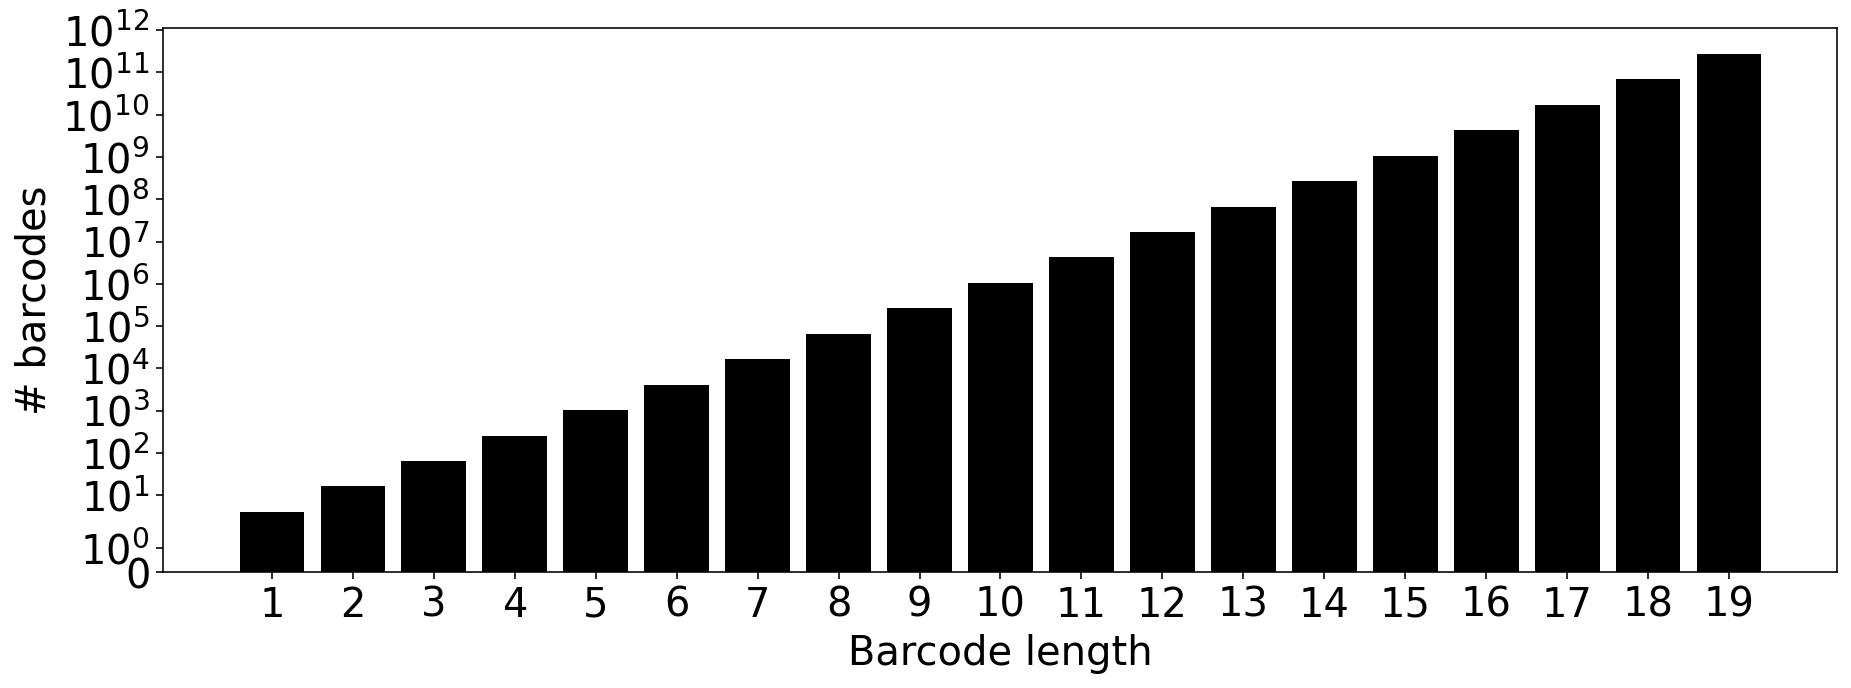

In [13]:
fig, ax = plt.subplots(figsize=(15,5))

x = np.arange (1, 20)
y = 4**x

ax.bar(x, y, color="k")
ax.set(**{
    "yscale": "symlog",
    "xticks": x,
    "xlabel": "Barcode length",
    "ylabel": "# barcodes"
})
fig.savefig("barcode_diversity.png", dpi=300, bbox_inches="tight")
fig.show()

# Simulation

In [14]:
# full bc
fbcs = [
  list("GGAGAAGA"),
  list("CCACAATG"),
  list("CCAACCGG"),
  list("CGAAGCCC"),
  list("TCAGTCGA"),
  list("GACCAGCC"),
  list("CTCAAGGT"),
  list("CGCCGCAA"),
  list("ACCAGCCG"),
]
# trim right
rbcs = [
  list("GGAGAAG"),
  list("CCACAAT"),
  list("CCAACCG"),
  list("CGAAGCC"),
  list("TCAGTCG"),
  list("GACCAGC"),
  list("CTCAAGG"),
  list("CGCCGCA"),
  list("ACCAGCC"),
]

# trim left
lbcs = [
  list("GAGAAGA"),
  list("CACAATG"),
  list("CAACCGG"),
  list("GAAGCCC"),
  list("CAGTCGA"),
  list("ACCAGCC"),
  list("TCAAGGT"),
  list("GCCGCAA"),
  list("CCAGCCG"),
]

bcs_names = [
"BC1",
"BC2",
"BC13",
"BC25",
"BC37",
"BC49",
"BC50",
"BC73",
"BC74",
]
bcs_list =[
"GGAGAAGA",
"CCACAATG",
"CCAACCGG",
"CGAAGCCC",
"TCAGTCGA",
"GACCAGCC",
"CTCAAGGT",
"CGCCGCAA",
"ACCAGCCG",
]
bcs = fbcs

# Check for shared kmer sequences in the forward and reverse strand

In [15]:
def gen_kmers(s, k):
  L = len(s)
  return [s[i:i+k] for i in range(L-k+1)]
gen_kmers("sina" ,3)

['sin', 'ina']

In [16]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
def rev_c(seq):
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases
rev_c("ATC")

'GAT'

In [17]:
from collections import defaultdict
def check_kmers(bcs, bcs_names, k=None):
  length = min([len(i) for i in bcs])
  if not k:
    k = length if length % 2 else length - 1
    print(f"Optimal kmer length: {k}")

  d = defaultdict(list)
  for bc, bc_name in zip(bcs, bcs_names):
    # forward
    kmers = gen_kmers(bc, k)
    for kmer in kmers:
      d["".join(kmer)].append(bc_name)
    
    # reverse complement
    kmers = gen_kmers(rev_c(bc), k)
    for kmer in kmers:
      d["".join(kmer)].append(bc_name + "_rc")
  return d

In [18]:
bc_len = len(bcs[0])
bc_len

8

In [19]:
check_kmers(bcs_list, bcs_names)

Optimal kmer length: 7


defaultdict(list,
            {'ACCAGCC': ['BC49', 'BC74'],
             'ACCTTGA': ['BC50_rc'],
             'ATTGTGG': ['BC2_rc'],
             'CAACCGG': ['BC13'],
             'CACAATG': ['BC2'],
             'CAGTCGA': ['BC37'],
             'CATTGTG': ['BC2_rc'],
             'CCAACCG': ['BC13'],
             'CCACAAT': ['BC2'],
             'CCAGCCG': ['BC74'],
             'CCGGTTG': ['BC13_rc'],
             'CCTTGAG': ['BC50_rc'],
             'CGAAGCC': ['BC25'],
             'CGACTGA': ['BC37_rc'],
             'CGCCGCA': ['BC73'],
             'CGGCTGG': ['BC74_rc'],
             'CGGTTGG': ['BC13_rc'],
             'CTCAAGG': ['BC50'],
             'CTTCTCC': ['BC1_rc'],
             'GAAGCCC': ['BC25'],
             'GACCAGC': ['BC49'],
             'GAGAAGA': ['BC1'],
             'GCCGCAA': ['BC73'],
             'GCTGGTC': ['BC49_rc'],
             'GGAGAAG': ['BC1'],
             'GGCTGGT': ['BC49_rc', 'BC74_rc'],
             'GGCTTCG': ['BC25_rc'],
             'GG

In [20]:
# across multiple kmer lengths
kmer_lens = np.arange(2, bc_len + 1)
ambig_bcs = []
for kmer_len in kmer_lens:
  # Determine the set of ambiguous barcodes
  ambig_bc = set()
  for i in check_kmers(bcs_list, bcs_names, kmer_len).values():
    if len(i) > 1:
      for j in i:
        ambig_bc.add(j.split("_")[0])
  ambig_bcs.append(len(ambig_bc))

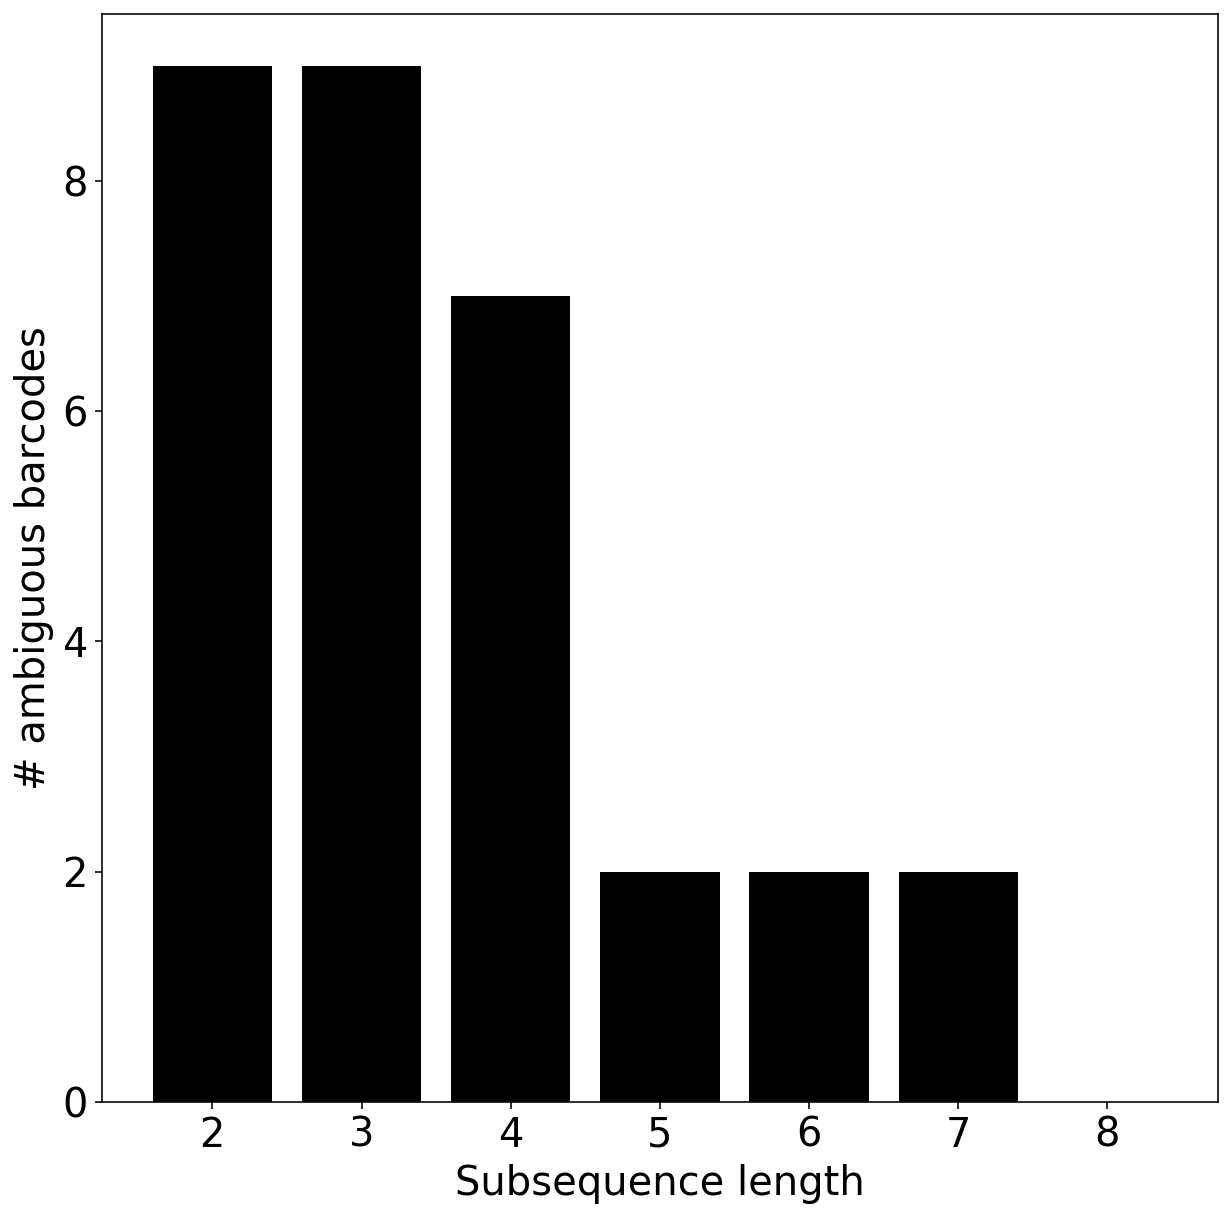

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

x = kmer_lens
y = ambig_bcs

ax.bar(x, y, color="k")
ax.set(**{
    "xticks": x,
    "xlabel": "Subsequence length",
    "ylabel": "# ambiguous barcodes"
})
fig.savefig("shared_subseq.png", dpi=300, bbox_inches="tight")

fig.show()

We see that BC49 and BC74 share kmers.
```
'ACCAGCC': ['BC49', 'BC74'],
'GGCTGGT': ['BC49_rc', 'BC74_rc'],
```






# Pairwise hamming / edit distance

In [22]:
n_bcs = len(bcs)
mat = np.zeros(( n_bcs, n_bcs ))
for i in range(len(bcs_list)):
  for j in range(i, len(bcs_list)):
    first  = np.array(list(bcs_list[i]))
    second = np.array(list(bcs_list[j]))
    mat[i,j] = (first!=second).sum()

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

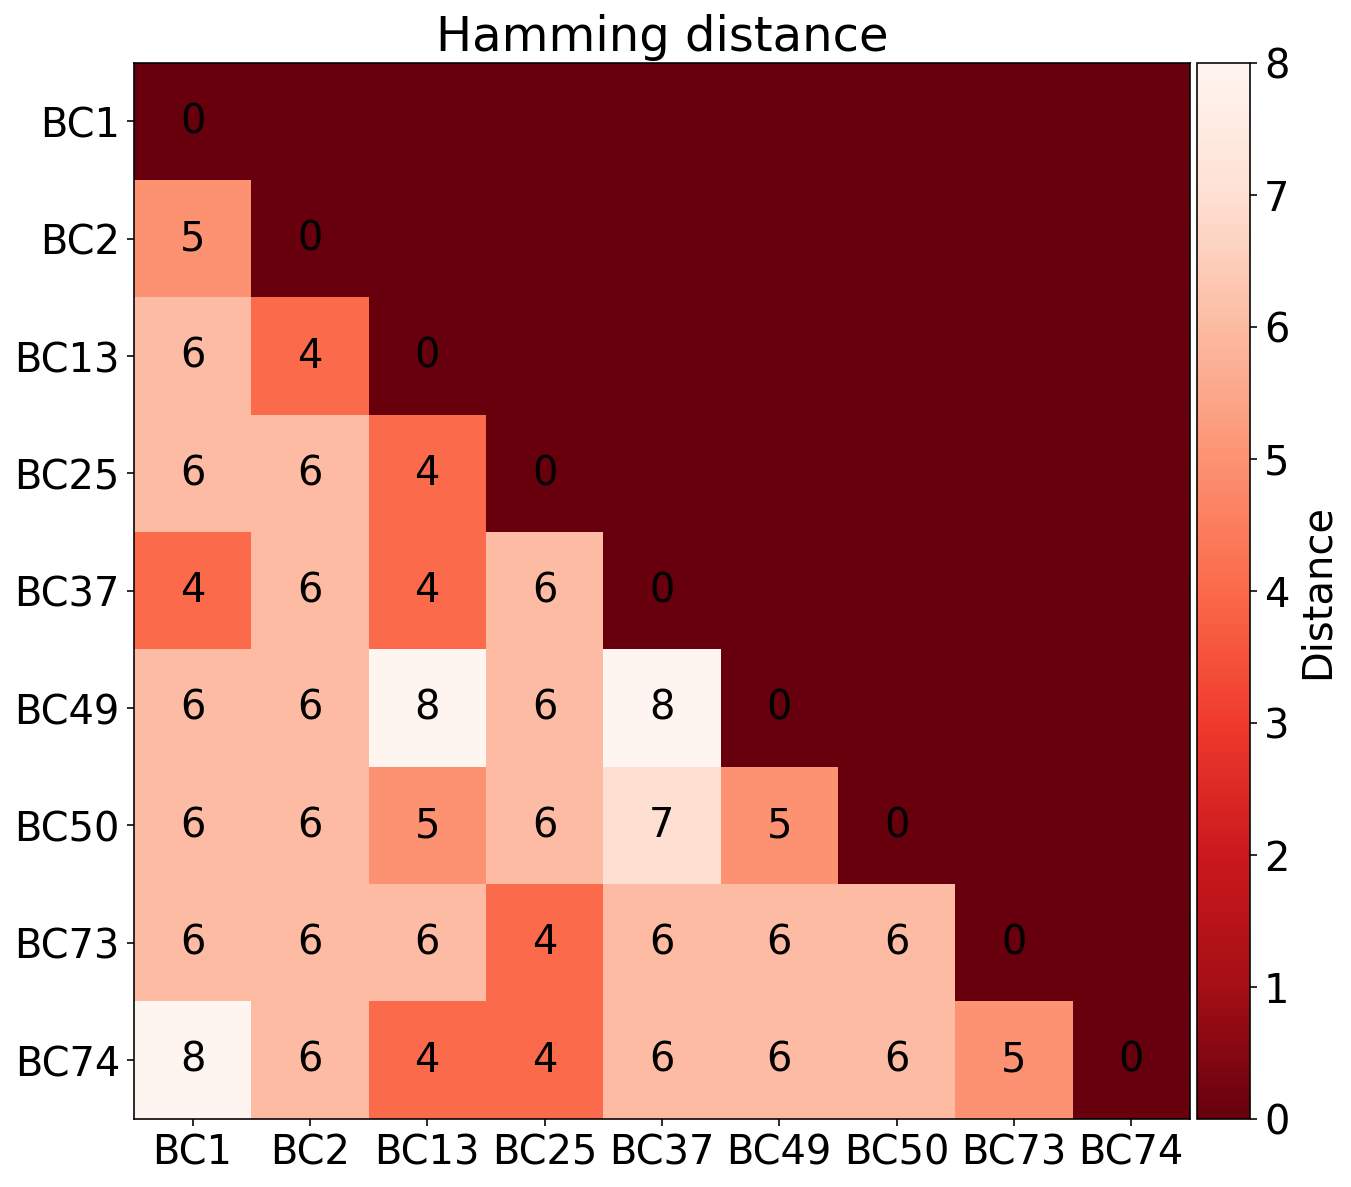

In [24]:

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(mat.T, cmap="Reds_r")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, label="Distance", cax=cax)

for (j,i),label in np.ndenumerate(mat.T):
  ham = mat[i,j]
  if i <= j:
    string = f"{ham:,.0f}"
    ax.text(i,j,string,ha='center',va='center')

ax.set(**{
    "xticklabels": bcs_names,
    "yticklabels": bcs_names,
    "xticks": np.arange(len(bcs_names)),
    "yticks": np.arange(len(bcs_names)),
    "title": "Hamming distance"
})

fig.savefig("pairwise.png", dpi=300, bbox_inches="tight")

fig.show()

# Simulate barcodes with errors and assign them (correct and unambiguous)

In [25]:
# Functions
# function, given a barcode, N, and error, return a list of mutants
def alt(barcode):
  # for each position the set of nucleotides that are not the given on
  d = set(["A", "T", "G", "C"])
  alt = [sorted(list(d.symmetric_difference(i))) for i in barcode]
  return alt

def mutate(barcode, N, err):
  barcode = list(barcode)
  bc_len = len(barcode)
  mutate_mask = np.random.rand(N,bc_len)<err

  # for each barcode for each base, the other possible nucleotide choices
  replace_opt = np.array(alt(barcode))

  # pick which of the 3 alternative nucleotides to change to
  replace_idx = np.random.choice(3, size=(N, bc_len))

  # select a single column for each row in replace_opt given by replace_idx 
  # do this for all N mutants, for each num_fb
  replace = np.array([replace_opt[np.arange(bc_len), i] for i in replace_idx]) 

  bc_mat = np.tile(barcode, (N, 1))

  # replace the nucleotides where mutate_mask is true
  bc_mat[mutate_mask] = replace[mutate_mask]
  ham = mutate_mask.sum(1)
  return (bc_mat, ham)

from collections import Counter
def distances(mutants, bcs_mat):
  # for each mutant, determine the set of hamming distances
  ham = []
  for idx, m in enumerate(mutants):    
    d = []
    for tidx, t in enumerate(bcs_mat):
      d.append((t!=m).sum())
    ham.append(d)

  ham = np.array(ham)
  return ham


def main(bcs, bc_len, N, max_ham_dist, err):
  mutants = []
  dist = []
  
  for bc in bcs:
    m, d = mutate(bc, N, err)
    mutants.append(m)
    dist.append(d)
  
  dist = np.concatenate(dist, 0)
  bcs_mat = np.array(bcs)
  mutants = np.concatenate(mutants, 0)
  mutant_origin = np.repeat(labels, N)
  total_dists = Counter(dist)
  ham = distances(mutants, bcs_mat)

  # Perform the assignment
  # [ min , max)
  # We want the maximum hamming after which it is ambiguous
  assign = []
  for h in ham:
    c = Counter(h)

    du = np.array([*c.keys()])
    du_argsort = np.argsort(du)

    one_idx, two_idx, *_ = du_argsort
    one_ham, two_ham = du[one_idx], du[two_idx]

    one_mul, two_mul = c[one_ham], c[two_ham]
    if one_mul == 1:
      min_ham = one_ham
      max_ham = two_ham 
      target = np.where(h == one_ham)[0][0]
    elif one_mul > 1:
      min_ham = one_ham - 1
      max_ham = one_ham
      target = -1

    assign.append([target, min_ham,  max_ham])
  
  assign = np.array(assign)
  correct = np.equal(assign[:,0], mutant_origin)
  ambiguous = np.equal(assign[:,0], -1)
  
  mask = np.logical_and(correct, ~ambiguous)
  data = Counter(np.array(assign)[:,1][mask])
  N_sim = []
  N_gen = []
  for i in np.arange(max_ham_dist):
    N_gen.append(total_dists.get(i))
    N_sim.append(data.get(i))
  return (N_gen, N_sim)



In [26]:
N = 20_000
bc_len = 8
max_ham = 7
n_bcs = len(bcs)
labels = np.arange(n_bcs)
np.random.seed(0)


In [27]:
err = np.linspace(0.001, 0.15, 10)

In [28]:
err

array([0.001     , 0.01755556, 0.03411111, 0.05066667, 0.06722222,
       0.08377778, 0.10033333, 0.11688889, 0.13344444, 0.15      ])

In [29]:
%%time
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(bcs, bc_len, N, max_ham, e)
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim)
gen = np.array(gen)
gen[np.where(gen==None)] = np.nan
sim[np.where(sim==None)] = 0

data = (sim/gen).astype(float)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 2min 2s, sys: 6.34 s, total: 2min 8s
Wall time: 2min 1s


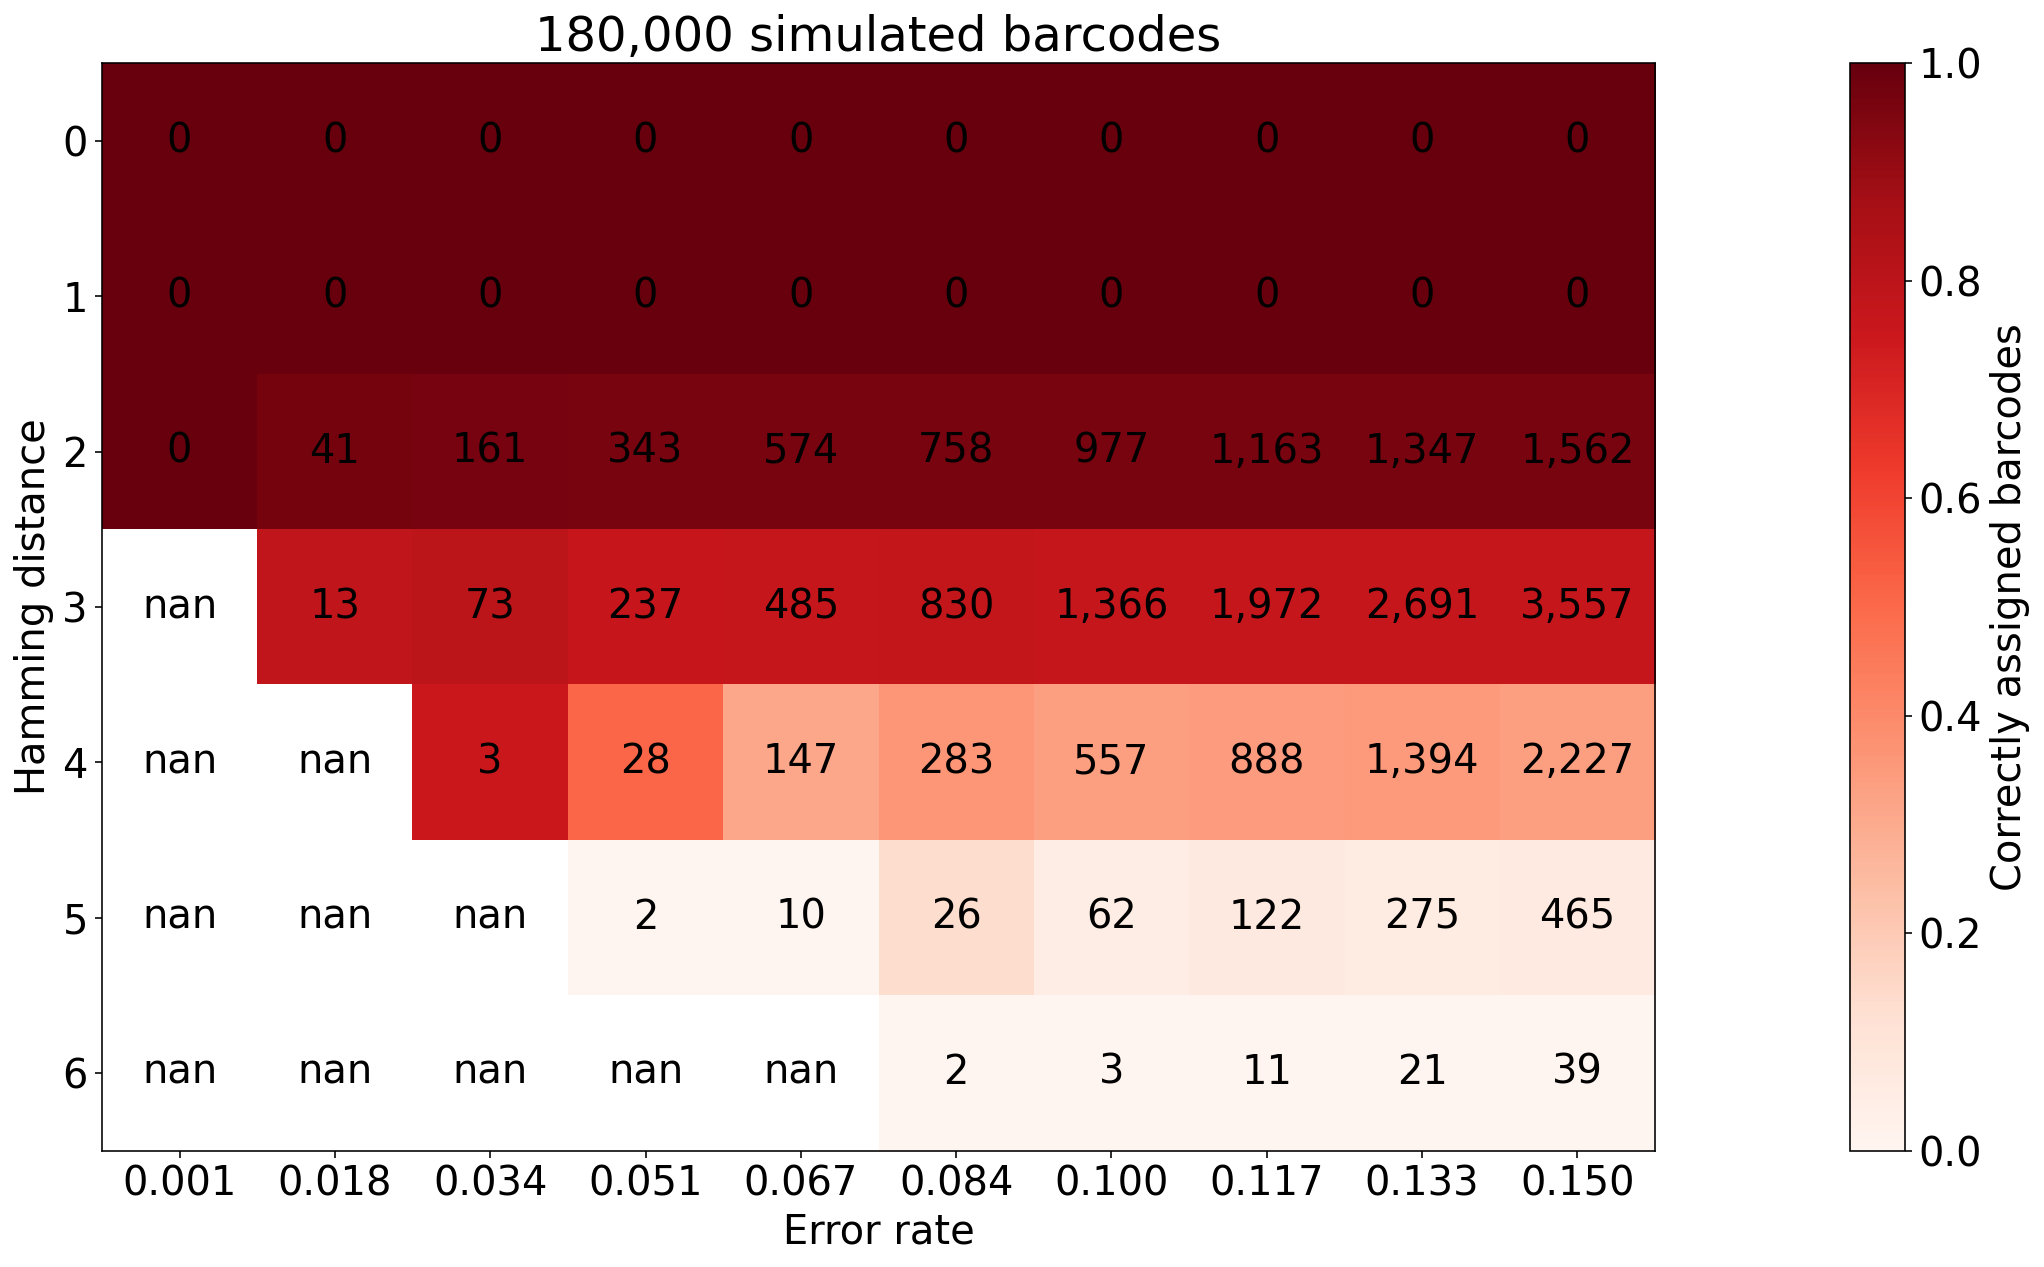

In [30]:
fig, ax = plt.subplots(figsize=(35,10))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, label="Correctly assigned barcodes")
errors = [f"{i:,.3f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance",
    "title": f"{N*n_bcs:,.0f} simulated barcodes"
})

for (j,i),label in np.ndenumerate(data.T):
  lost = gen[i,j] - sim[i,j]
  string = f"{lost:,.0f}"
  ax.text(i,j,string,ha='center',va='center')

fig.show()

In [31]:
f"{lost:,}"

'39'

In [32]:
# generate random list of barcodes and compare
def gen_random(N, bc_len):
  nuc_opts = np.tile(["A","T","G","C"], (N,bc_len,1))
  replace_idx = np.random.choice(4, size=(N, bc_len))
  replace = np.array([nuc_opts[idx][np.arange(bc_len), i] for idx, i in enumerate(replace_idx)]) 
  return replace

In [33]:
random_barcodes = gen_random(n_bcs, bc_len)

In [34]:
random_barcodes

array([['C', 'T', 'G', 'C', 'G', 'A', 'G', 'G'],
       ['G', 'T', 'C', 'C', 'T', 'G', 'T', 'C'],
       ['T', 'C', 'A', 'C', 'T', 'A', 'C', 'T'],
       ['T', 'G', 'A', 'A', 'A', 'T', 'G', 'C'],
       ['C', 'C', 'C', 'A', 'C', 'T', 'A', 'A'],
       ['G', 'G', 'T', 'A', 'G', 'G', 'T', 'G'],
       ['C', 'C', 'A', 'A', 'C', 'G', 'C', 'G'],
       ['A', 'A', 'G', 'T', 'T', 'C', 'A', 'C'],
       ['G', 'C', 'A', 'C', 'C', 'A', 'G', 'T']], dtype='<U1')

In [35]:
%%time
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(random_barcodes, bc_len, N, max_ham, e)
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim)
gen = np.array(gen)
gen[np.where(gen==None)] = np.nan
sim[np.where(sim==None)] = 0

data = (sim/gen).astype(float)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 2min, sys: 5.57 s, total: 2min 6s
Wall time: 2min


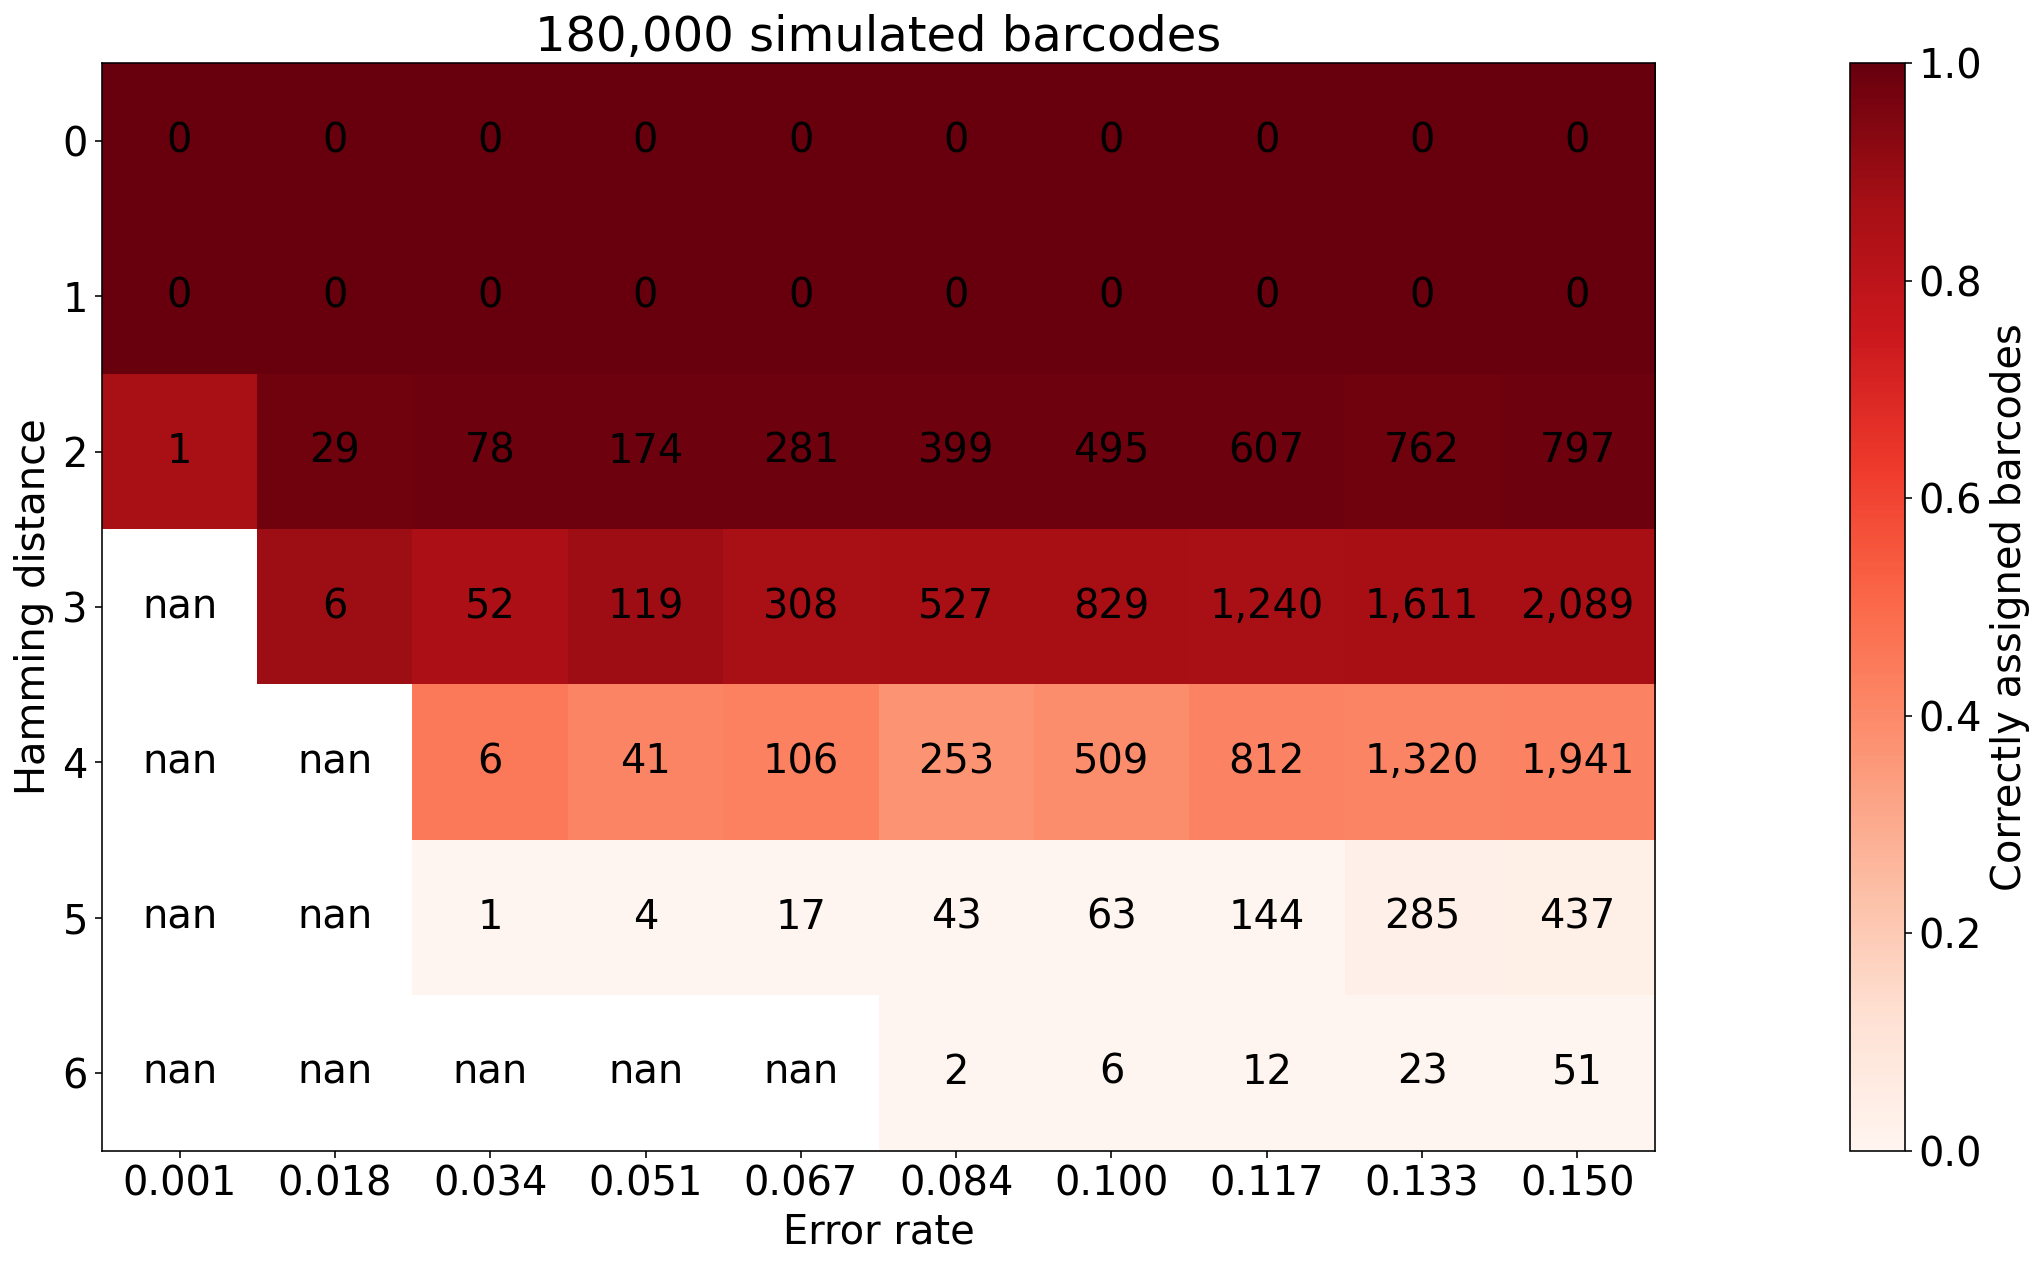

In [36]:
fig, ax = plt.subplots(figsize=(35,10))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, label="Correctly assigned barcodes")
errors = [f"{i:,.3f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance",
    "title": f"{N*n_bcs:,.0f} simulated barcodes"
})

for (j,i),label in np.ndenumerate(data.T):
  lost = gen[i,j] - sim[i,j]
  string = f"{lost:,.0f}"
  ax.text(i,j,string,ha='center',va='center')

fig.show()

# All together

In [37]:
%%time

# Given bcs
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(bcs, bc_len, N, max_ham, e)
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim)
gen = np.array(gen)
gen[np.where(gen==None)] = np.nan
sim[np.where(sim==None)] = 0

data = (sim/gen).astype(float)

# Random bcs
random_barcodes = gen_random(n_bcs, bc_len)

r_sim = []
r_gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(random_barcodes, bc_len, N, max_ham, e)
  r_sim.append(N_sim)
  r_gen.append(N_gen)

r_sim = np.array(r_sim)
r_gen = np.array(r_gen)
r_gen[np.where(r_gen==None)] = np.nan
r_sim[np.where(r_sim==None)] = 0

r_data = (r_sim/r_gen).astype(float)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 4min 3s, sys: 11.2 s, total: 4min 14s
Wall time: 4min 2s


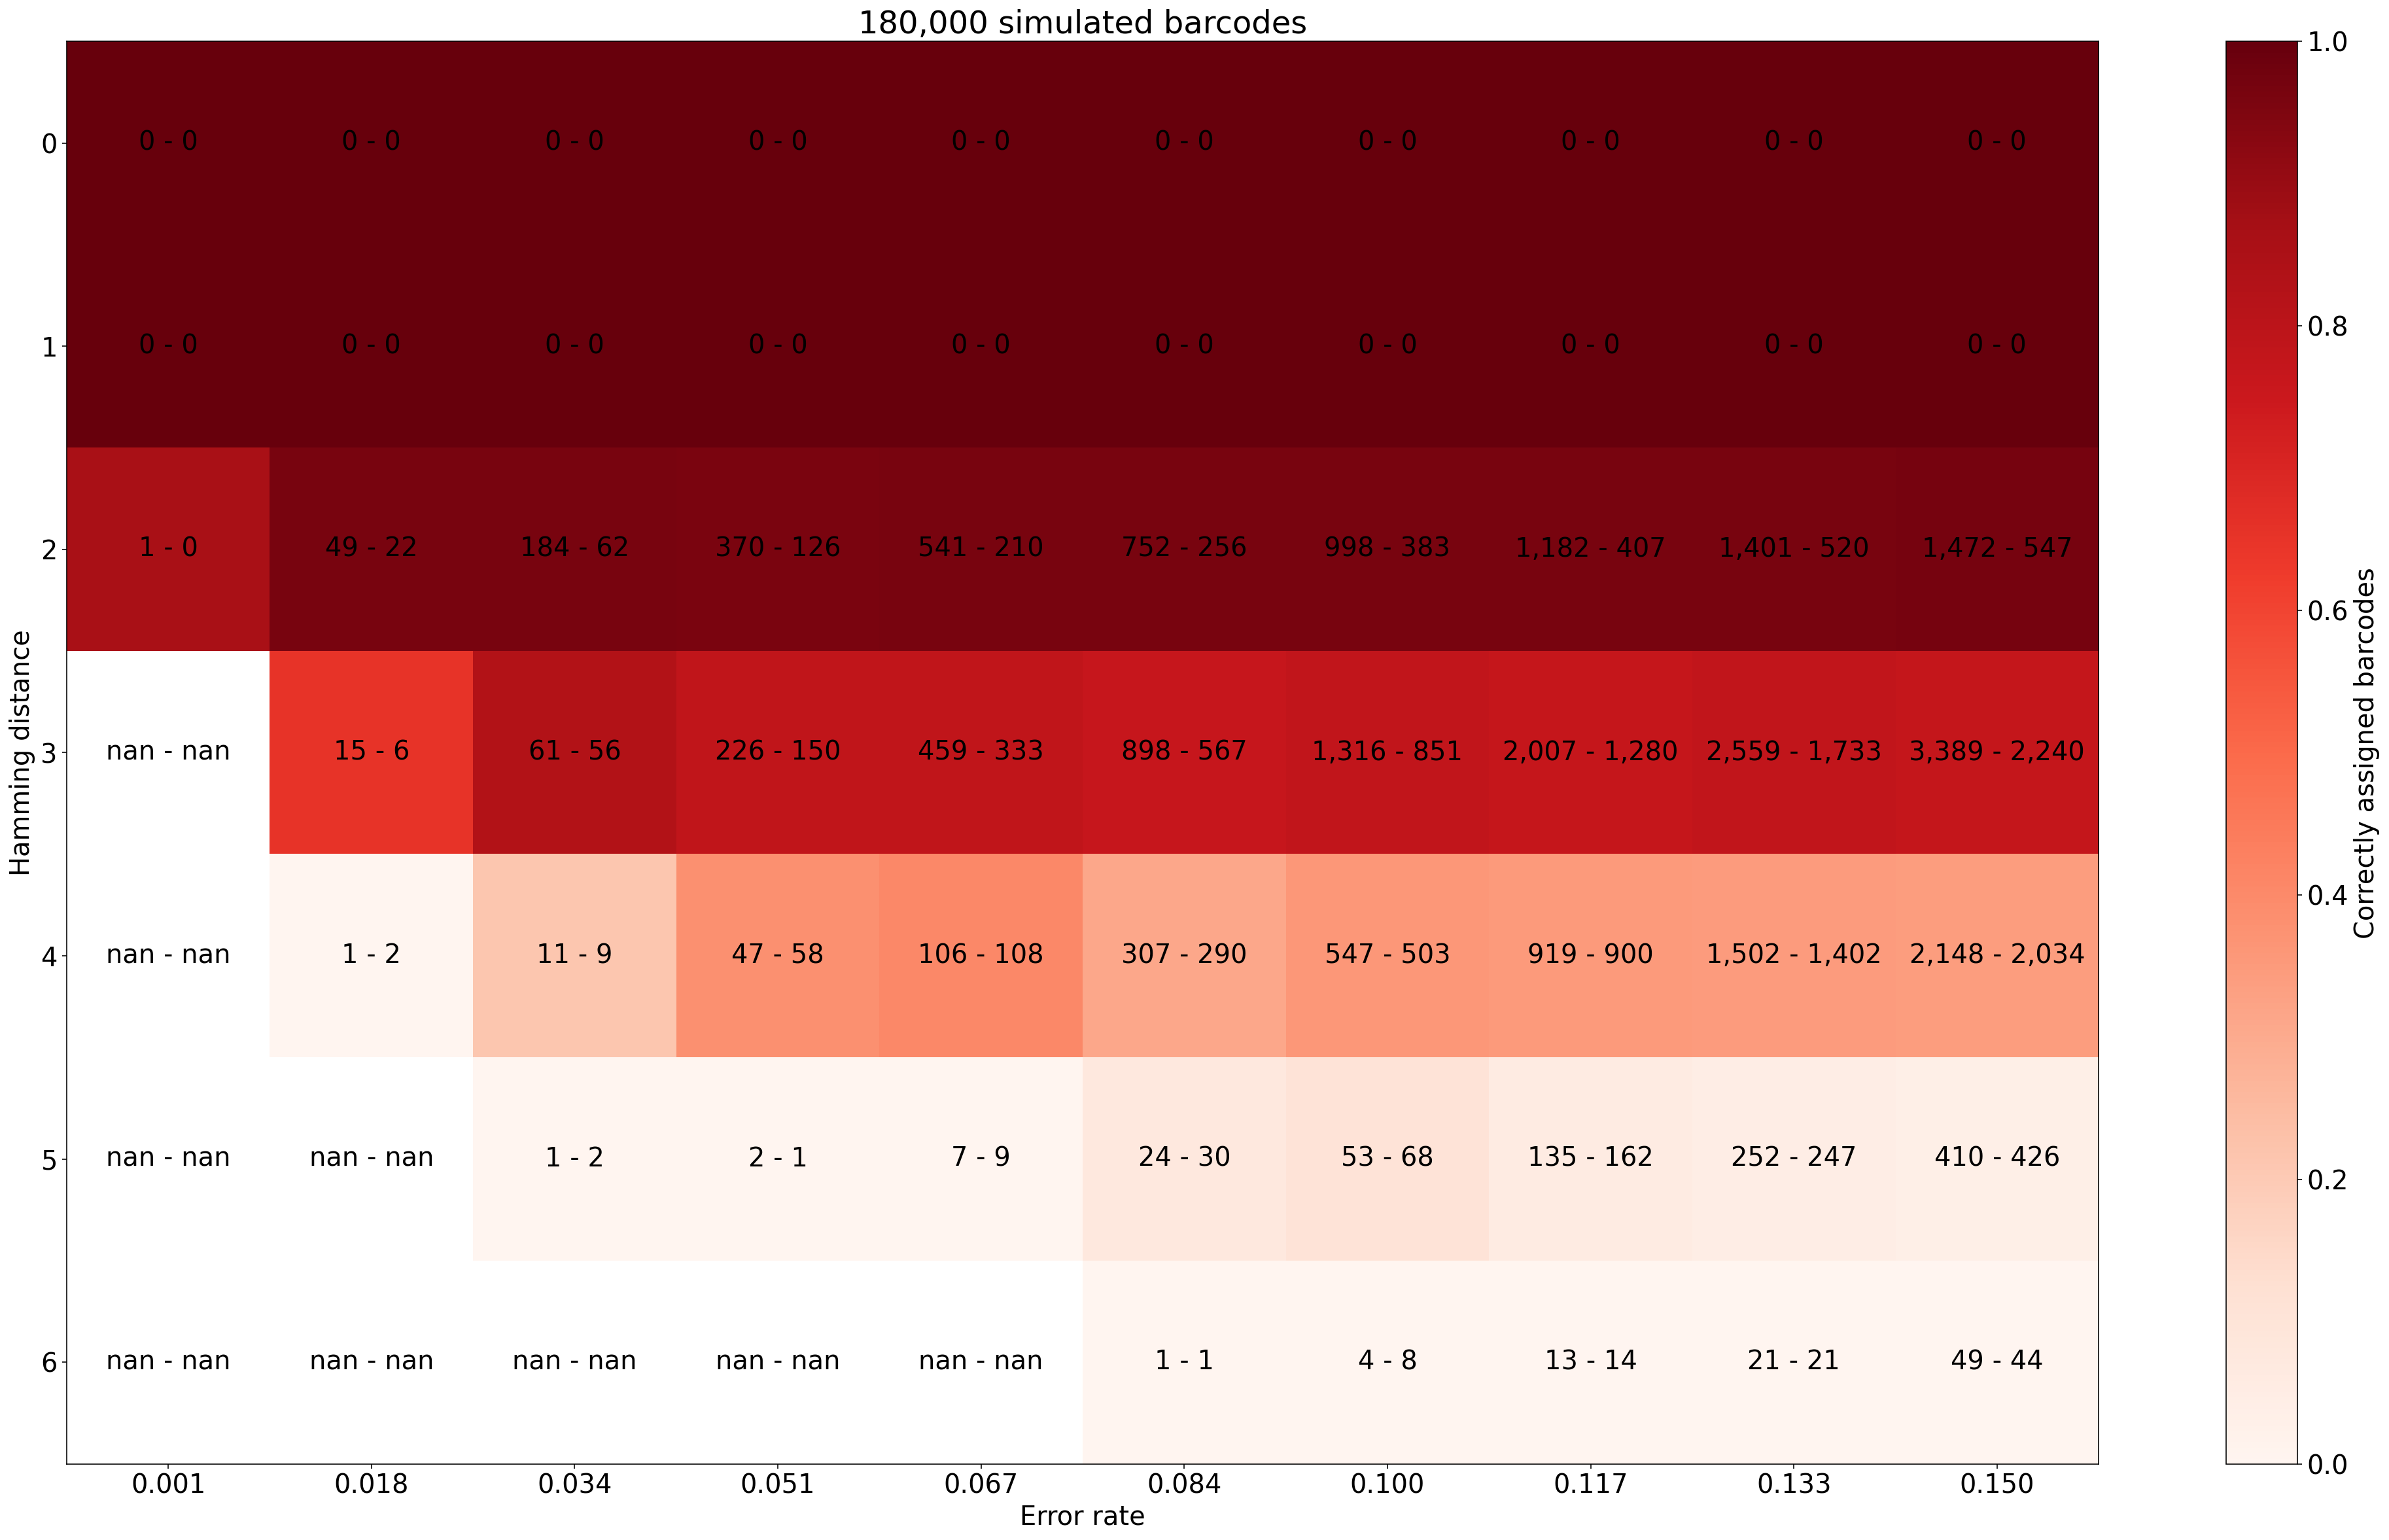

In [38]:
fig, ax = plt.subplots(figsize=(35,20))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, label="Correctly assigned barcodes")
errors = [f"{i:,.3f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance",
    "title": f"{N*n_bcs:,.0f} simulated barcodes"
})

for (j,i),label in np.ndenumerate(data.T):
  lost = gen[i,j] - sim[i,j]
  r_lost = r_gen[i,j] - r_sim[i,j]
  string = f"{lost:,.0f} - {r_lost:,.0f}"
  ax.text(i,j,string,ha='center',va='center')
fig.savefig("sim_cmp.png")
fig.show()